In [7]:
import pandas as pd
import numpy as np

num_cols = [
    "loan_amount", "loan_to_value_ratio", "interest_rate", "rate_spread",
    "total_loan_costs", "total_points_and_fees", "origination_charges",
    "discount_points", "lender_credits", "loan_term",
    "prepayment_penalty_term", "intro_rate_period", "property_value",
    "total_units", "multifamily_affordable_units", "income",
    "tract_population", "tract_minority_population_percent",
    "ffiec_msa_md_median_family_income", "tract_to_msa_income_percentage",
    "tract_owner_occupied_units", "tract_one_to_four_family_homes",
    "tract_median_age_of_housing_units"
]

cat_cols = [
    "lei", "derived_msa-md", "state_code", "county_code",
    "census_tract", "conforming_loan_limit", "derived_loan_product_type",
    "derived_dwelling_category", "derived_ethnicity", "derived_race",
    "derived_sex", "action_taken", "purchaser_type", "preapproval",
    "loan_type", "loan_purpose", "lien_status", "reverse_mortgage",
    "open-end_line_of_credit", "business_or_commercial_purpose",
    "construction_method", "occupancy_type",
    "manufactured_home_secured_property_type",
    "manufactured_home_land_property_interest",
    "applicant_credit_score_type", "co-applicant_credit_score_type",
    "applicant_ethnicity_observed", "co-applicant_ethnicity_observed",
    "applicant_race_observed", "co-applicant_race_observed",
    "applicant_sex", "co-applicant_sex", "applicant_sex_observed",
    "co-applicant_sex_observed", "applicant_age_above_62",
    "co-applicant_age_above_62", "submission_of_application",
    "initially_payable_to_institution",
    "negative_amortization", "interest_only_payment",
    "balloon_payment", "other_nonamortizing_features"
]

multi_slot_cols = [
    "applicant_ethnicity-1","applicant_ethnicity-2","applicant_ethnicity-3",
    "applicant_ethnicity-4","applicant_ethnicity-5",
    "co-applicant_ethnicity-1","co-applicant_ethnicity-2",
    "co-applicant_ethnicity-3","co-applicant_ethnicity-4",
    "co-applicant_ethnicity-5",
    "applicant_race-1","applicant_race-2","applicant_race-3",
    "applicant_race-4","applicant_race-5",
    "co-applicant_race-1","co-applicant_race-2",
    "co-applicant_race-3","co-applicant_race-4","co-applicant_race-5",
    "aus-1","aus-2","aus-3","aus-4","aus-5",
    "denial_reason-1","denial_reason-2","denial_reason-3","denial_reason-4"
]

empty_col_threshold = 600 # Borrar columnas con menos de x datos no nulos en ellas

df = pd.read_csv("pwc_dataset.csv", sep=';')

print(df.shape)
print(df.info())
print(df.head())

missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)



desc_num = df[num_cols].describe().T
desc_cat = df[cat_cols].describe().T



for col in ["action_taken", "loan_purpose", "loan_type",
            "derived_race", "derived_ethnicity", "derived_sex"]:
    print(col, df[col].value_counts(dropna=False).head(20))

for col in num_cols:
    df[col] = df[col].astype(str).str.replace(',', '.', regex=False)




print("\n=== DEBUG NUMERIC CONVERSION ERRORS ===")

# Keep track of rows to drop
rows_to_drop = set()

for col in num_cols:
    for idx, val in df[col].items():
        try:
            # Replace comma with dot and try conversion
            float(str(val).replace(',', '.'))
        except Exception:
            print(f"[ERROR] Column '{col}', Row {idx}, Bad Value: '{val}'")
            rows_to_drop.add(idx)

# Drop all offending rows at once
if rows_to_drop:
    print(f"\n[DROPPING] {len(rows_to_drop)} rows due to invalid numeric values.")
    df = df.drop(index=rows_to_drop)

print(f"Rows remaining after drop: {df.shape[0]}")


#corr = df[num_cols].corr()



C:\Users\JAVI\AppData\Local\Temp\ipykernel_2880\2679928769.py:53: DtypeWarning: Columns (21,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("pwc_dataset.csv", sep=';')


(200000, 99)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 99 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   activity_year                             200000 non-null  int64  
 1   lei                                       200000 non-null  object 
 2   derived_msa-md                            200000 non-null  int64  
 3   state_code                                198617 non-null  object 
 4   county_code                               198627 non-null  float64
 5   census_tract                              198627 non-null  float64
 6   conforming_loan_limit                     199710 non-null  object 
 7   derived_loan_product_type                 200000 non-null  object 
 8   derived_dwelling_category                 200000 non-null  object 
 9   derived_ethnicity                         200000 non-null  object 
 10  derived

# Análisis estadístico de los datos
Objetivo: detectar valores fuera de lo normal

In [8]:
print("\n=== OUTLIER DETECTION (IQR METHOD) ===")

# Columns to exclude from outlier detection
excluded_cols = {}

# Prepare storage
outlier_positions = []
total_rows = df.shape[0]

# Filter numeric columns to analyze
cols_to_check = [c for c in num_cols if c not in excluded_cols]

for col in cols_to_check:
    # Convert safely to numeric
    df[col] = pd.to_numeric(df[col], errors='coerce')
    series = df[col].dropna()

    if series.empty:
        continue

    # Calculate IQR
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    outliers = df[mask][col]

    for idx, val in outliers.items():
        outlier_positions.append((idx, col, val))
        #print(f"[OUTLIER] Row {idx}, Column '{col}', Value: {val}")

# Summary
print("\n=== OUTLIER SUMMARY ===")
print(f"Total rows analyzed: {total_rows}")
print(f"Total outliers detected: {len(outlier_positions)}")

outlier_counts = pd.Series([c for _, c, _ in outlier_positions]).value_counts()
print("\nOutliers per column:")
print(outlier_counts)


=== OUTLIER DETECTION (IQR METHOD) ===

=== OUTLIER SUMMARY ===
Total rows analyzed: 199710
Total outliers detected: 167107

Outliers per column:
loan_term                            62194
ffiec_msa_md_median_family_income    16275
income                               14768
loan_amount                          14708
property_value                       11633
tract_to_msa_income_percentage        7749
intro_rate_period                     7668
origination_charges                   5030
tract_population                      4690
lender_credits                        4089
total_loan_costs                      3374
tract_one_to_four_family_homes        3307
total_units                           2941
tract_owner_occupied_units            2866
discount_points                       1939
loan_to_value_ratio                   1619
rate_spread                           1325
interest_rate                          922
total_points_and_fees                   10
Name: count, dtype: int64


# Borrar Columnas vacías (o casi vacías)

In [9]:
print("\n=== ROBUST DROPPING OF EMPTY / NA-LIKE COLUMNS ===")

na_like_tokens = [
    "NA", "N/A", "Na", "n/a", "n\\a", "NULL", "null", "None", "none", "-", "--", "", "nan"
]

pattern = r'^(?i:(?:' + '|'.join([t.replace("\\", "\\\\").replace(".", r"\.") for t in na_like_tokens if t != ""]) + r'))$'

# For safety, also handle whitespace-only strings with a separate regex
df = df.replace(pattern, np.nan, regex=True)
df = df.replace(r'^\s*$', np.nan, regex=True)   # whitespace-only -> NaN

non_missing_counts = df.notna().sum()


low_data_cols = non_missing_counts[non_missing_counts < empty_col_threshold].index.tolist()

if low_data_cols:
    print(f"Found {len(low_data_cols)} empty or nearly empty columns: {low_data_cols}")
    df = df.drop(columns=low_data_cols)

all_nan_mask = df.isna().all()
empty_cols = all_nan_mask[all_nan_mask].index.tolist()

if empty_cols:
    print(f"\nFound {len(empty_cols)} completely empty columns: {empty_cols}")
    # Drop from dataframe
    df = df.drop(columns=empty_cols)
else:
    print("\nNo completely empty columns found.")
    
num_cols = [c for c in num_cols if c not in empty_cols and c not in low_data_cols]
cat_cols = [c for c in cat_cols if c not in empty_cols and c not in low_data_cols]
multi_slot_cols = [c for c in multi_slot_cols if c not in empty_cols and c not in low_data_cols]

    


print(f"\nRemaining columns in DataFrame: {len(df.columns)}")
print(f"Remaining numeric columns: {len(num_cols)}")
print(f"Remaining categorical columns: {len(cat_cols)}")
print(f"Remaining multi-slot columns: {len(multi_slot_cols)}")




=== ROBUST DROPPING OF EMPTY / NA-LIKE COLUMNS ===
Found 20 empty or nearly empty columns: ['total_points_and_fees', 'prepayment_penalty_term', 'multifamily_affordable_units', 'applicant_ethnicity-3', 'applicant_ethnicity-4', 'applicant_ethnicity-5', 'co-applicant_ethnicity-3', 'co-applicant_ethnicity-4', 'co-applicant_ethnicity-5', 'applicant_race-3', 'applicant_race-4', 'applicant_race-5', 'co-applicant_race-3', 'co-applicant_race-4', 'co-applicant_race-5', 'aus-3', 'aus-4', 'aus-5', 'denial_reason-3', 'denial_reason-4']

No completely empty columns found.

Remaining columns in DataFrame: 79
Remaining numeric columns: 20
Remaining categorical columns: 42
Remaining multi-slot columns: 12


# Matriz de correlación

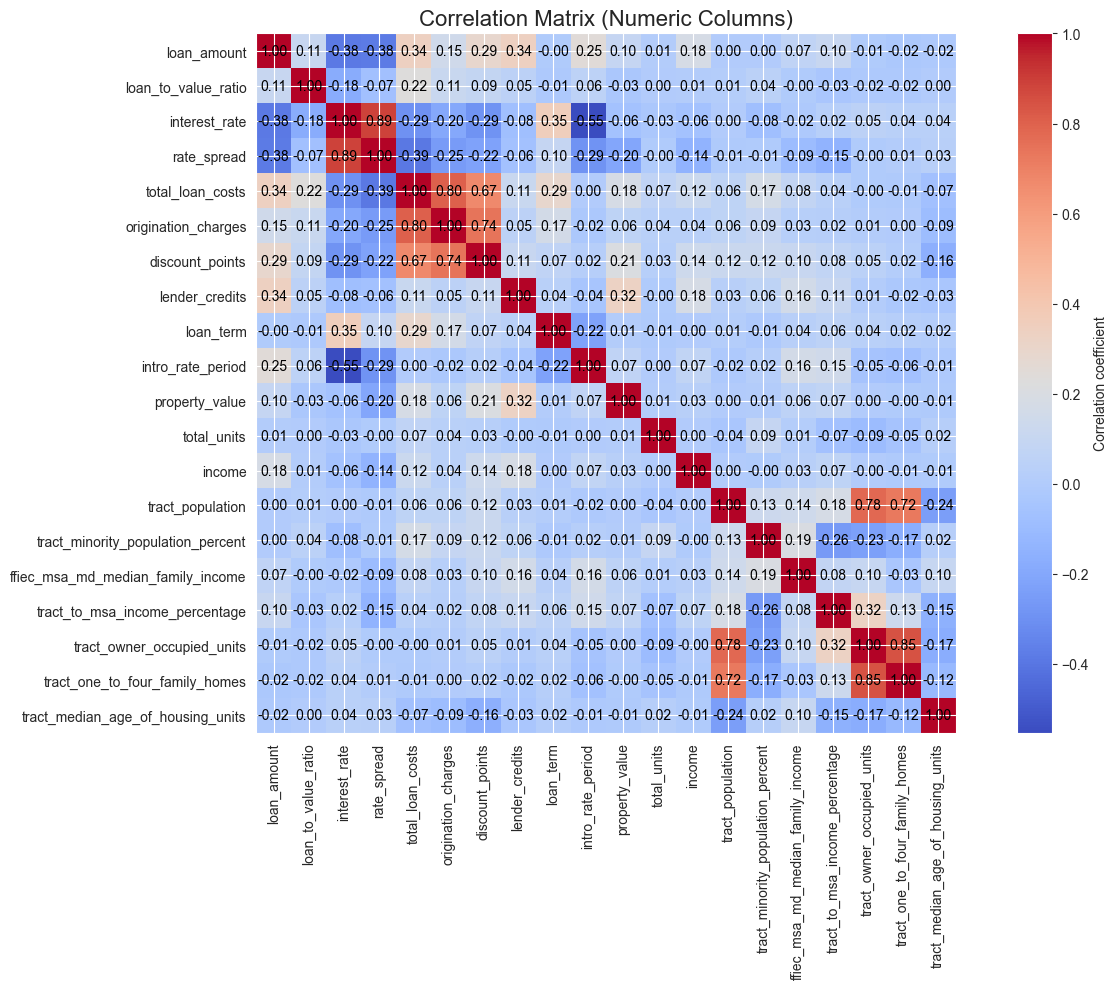

In [17]:
plt.figure(figsize=(14, 10))
plt.title("Correlation Matrix (Numeric Columns)", fontsize=16)

# Draw heatmap
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')

# Add colorbar
plt.colorbar(label='Correlation coefficient')

# Tick labels
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

# Annotate each cell with numeric value
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        value = corr_matrix.iloc[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='black')

plt.tight_layout()
plt.show()



=== CORRELATION MATRIX (SELECTED CATEGORICAL COLUMNS ENCODED) ===
                                 state_code  county_code  derived_ethnicity  \
state_code                         1.000000     0.991755           0.029053   
county_code                        0.991755     1.000000           0.030749   
derived_ethnicity                  0.029053     0.030749           1.000000   
derived_race                       0.049302     0.047170          -0.030971   
derived_sex                        0.017916     0.018868          -0.495833   
action_taken                       0.002643    -0.005820          -0.276720   
purchaser_type                     0.031426     0.029270          -0.179921   
loan_type                          0.023717     0.021678          -0.088977   
loan_purpose                       0.036792     0.040100           0.097124   
occupancy_type                    -0.016002    -0.014363          -0.019138   
applicant_credit_score_type       -0.076452    -0.081642        

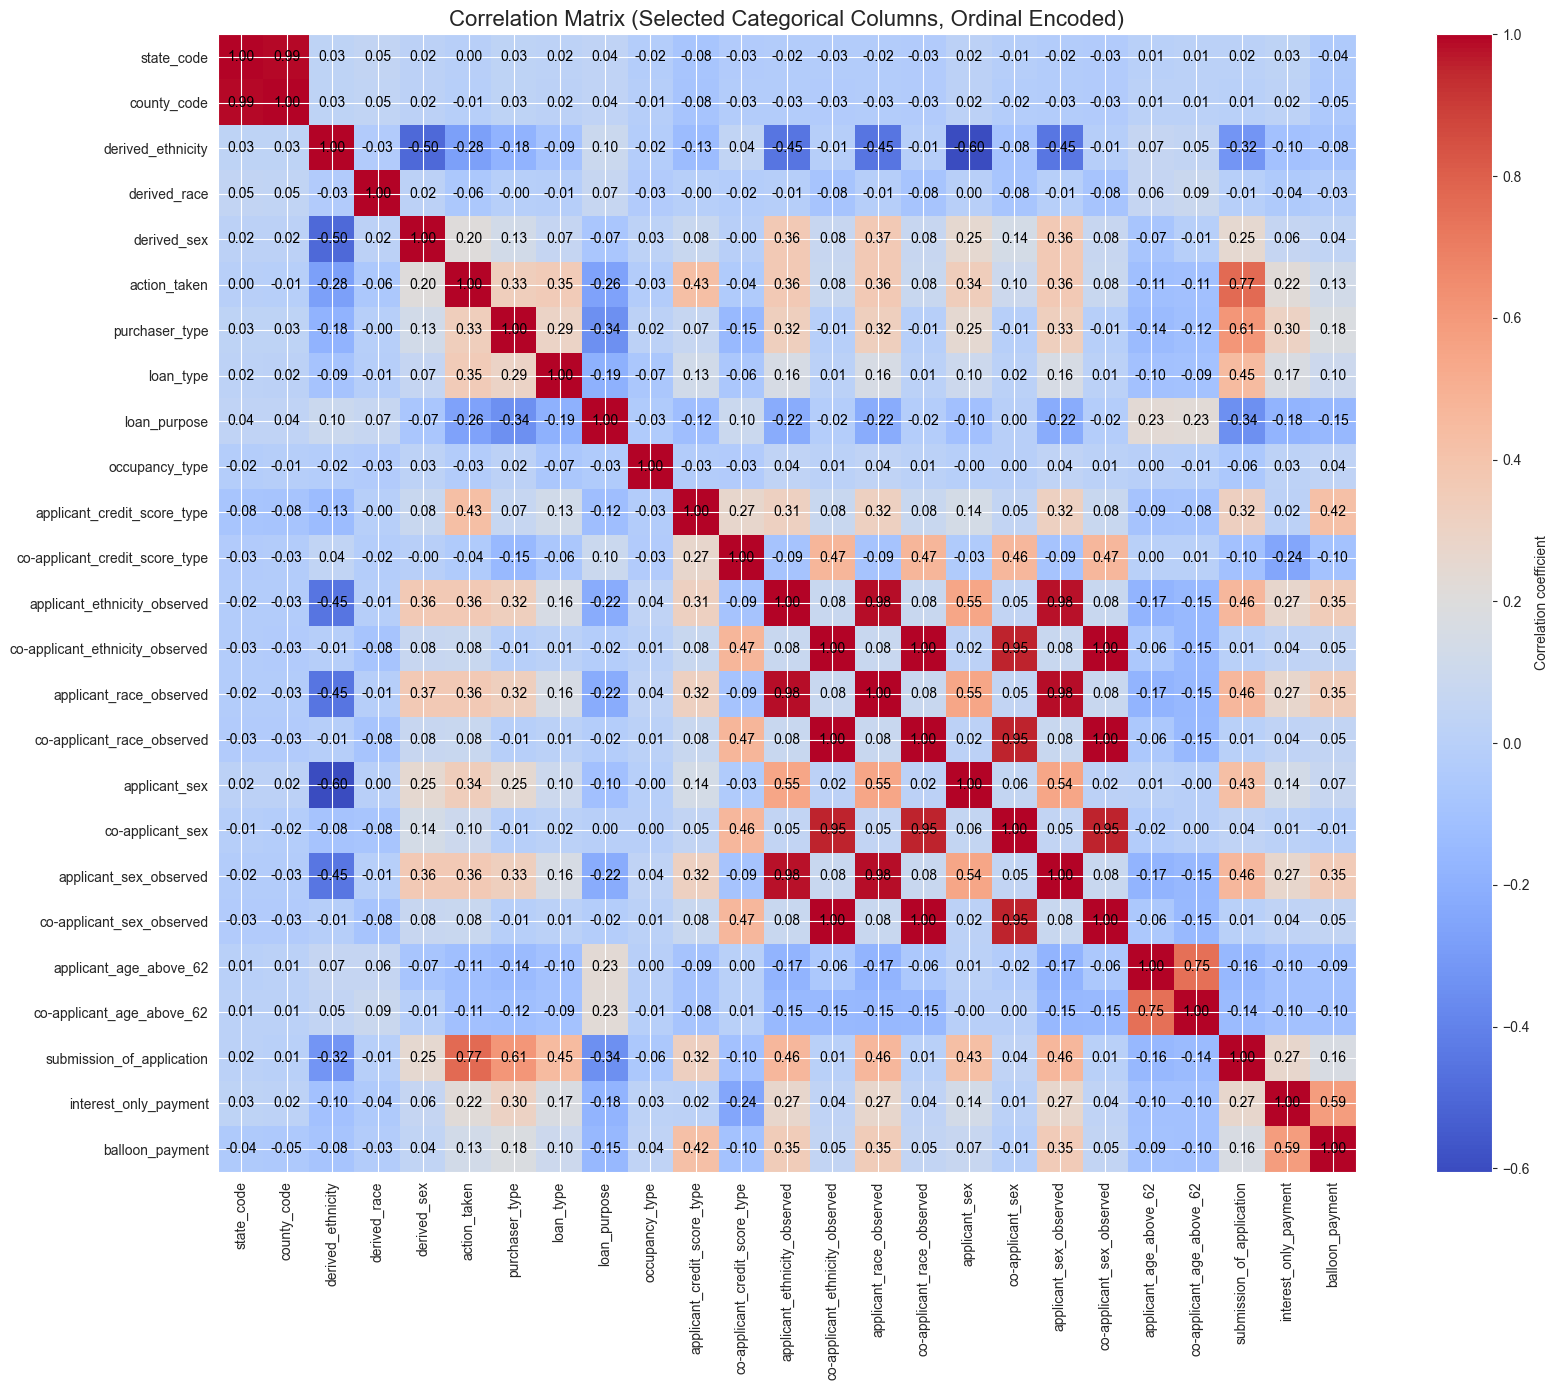

In [22]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import matplotlib.pyplot as plt

selected_cat_cols = [
    "state_code", "county_code",
    "derived_ethnicity", "derived_race",
    "derived_sex", "action_taken", "purchaser_type",
    "loan_type", "loan_purpose", "occupancy_type",
    "applicant_credit_score_type", "co-applicant_credit_score_type",
    "applicant_ethnicity_observed", "co-applicant_ethnicity_observed",
    "applicant_race_observed", "co-applicant_race_observed",
    "applicant_sex", "co-applicant_sex", "applicant_sex_observed",
    "co-applicant_sex_observed", "applicant_age_above_62",
    "co-applicant_age_above_62", "submission_of_application", "interest_only_payment",
    "balloon_payment"
]

# Subset dataframe to selected categorical columns
cat_df = df[selected_cat_cols].copy()

# Encode categorical variables into numeric
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
cat_encoded = encoder.fit_transform(cat_df)

encoded_df = pd.DataFrame(cat_encoded, columns=selected_cat_cols)

# Compute correlation matrix
cat_corr = encoded_df.corr(method='pearson')

print("\n=== CORRELATION MATRIX (SELECTED CATEGORICAL COLUMNS ENCODED) ===")
print(cat_corr)

# Plot heatmap with annotations
plt.figure(figsize=(18, 14))
plt.title("Correlation Matrix (Selected Categorical Columns, Ordinal Encoded)", fontsize=16)

plt.imshow(cat_corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation coefficient')

plt.xticks(range(len(cat_corr.columns)), cat_corr.columns, rotation=90)
plt.yticks(range(len(cat_corr.columns)), cat_corr.columns)

# Annotate values on the heatmap
for i in range(len(cat_corr.columns)):
    for j in range(len(cat_corr.columns)):
        value = cat_corr.iloc[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='black')

plt.tight_layout()
plt.show()


# Acerca de GAN (Generative Adversarial Network)
## La red generativa
El generador de contenido sesgado tiene un vector de ruido. Este vector generará los datos sesgados y se irá volviendo más preciso con cada iteración.
### Componentes de la red generativa
A continuación se muestran algunas capas de interés para nuestro caso (GAN con CSV de input), presentes en la librería Keras
- capa Dense: la capa de ruido. Está totalmente conectada
- capa leakyReLU: Decide cómo se transforman los valores de salida de una neurona. En este caso, a diferencia de ReLU, esta capa permite un pequeño gradiente cuando la entrada sea negativa. Evita que las neuronas queden desactivadas durante el entrenamiento, permitiendo un aprendizaje más rápido
- capa dropout: apaga aleatoriamente un procentaje de neuronas durante cada iteración. Evita que la red se vuelva dependiente de algunas neuronas. Evita que el detector de sesgos no esté con una ventaja excesiva durante el entrenamiento.
- capa dense con sigmoide: quiere decir que la salida estará entre 0 y 1 con una función sigmoidal. 
- embedding: convierte índices de categorías en vectores densos. Conveniente si una variable categórica tiene muchos valores.
- capa de normalización (Batch Normalization): normalizar una salida de una capa, mejora estabilidad si usamos muchas capas Dense.
- capa de ruido Gaussiano: añade ruido gaussiano durante el entrenamiento. Si el detector de sesgo se adapta demasiado bien, se puede añadir esta capa para regularlo
- capa de concatenación: junta varias salidas de capa en 1 sola (usar si se procesan columnas por separado que luego se quieren unir)
- capa de activación:
- capa de aplanar o reformadora: cambian la dimensionalidad de un tensor. En este caso no se espera usar ningún tensor que no sea 1D.




In [11]:
# gan_table_example.py
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import json
import os
'''
# === Preprocessor ===
class TablePreprocessor:
    """
    Fit on a DataFrame to learn numeric scalers, categorical maps, and
    possible values for multi-slot columns. Use transform() to convert rows
    to a numeric vector suitable for the discriminator, and
    inverse_transform_generator_output() to map generator raw output
    to human-readable row format.
    """
    def __init__(self, num_cols, cat_cols, multi_slot_cols):
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.multi_slot_cols = multi_slot_cols

        self.num_scaler = StandardScaler()
        # For each categorical column map value->int and store cardinality
        self.cat_maps = {}       # col -> {val: idx}
        self.cat_cardinalities = {}  # col -> int
        # For each multi-slot column we will compute the set of unique labels across all slot positions
        self.multi_slot_vocabs = {}  # base prefix -> list of unique values
        self.output_structure = []  # list describing slices in final vector

    def fit(self, df):
        # Fit numeric scaler
        num_df = df[self.num_cols].astype(float).fillna(0.0)
        self.num_scaler.fit(num_df)

        # Fit categorical maps
        for c in self.cat_cols:
            series = df[c].astype(str).fillna("<<NA>>")
            uniques = list(series.unique())
            # keep stable ordering
            uniques_sorted = sorted(uniques)
            mapping = {v: i for i, v in enumerate(uniques_sorted)}
            self.cat_maps[c] = mapping
            self.cat_cardinalities[c] = len(mapping)

        # Fit multi-slot vocabs
        # For multi-slot columns the names contain suffixes like "-1", "-2".
        # Group by the prefix before the last '-' to compute a vocabulary.
        prefix_groups = {}
        for col in self.multi_slot_cols:
            # attempt to extract prefix
            if "-" in col:
                prefix = col.rsplit("-", 1)[0]
            else:
                prefix = col
            prefix_groups.setdefault(prefix, []).append(col)

        for prefix, slots in prefix_groups.items():
            # collect unique values among these columns in the dataset
            values = set()
            for s in slots:
                values.update(df[s].astype(str).fillna("<<NA>>").unique())
            # stable list
            vocab = sorted(values)
            self.multi_slot_vocabs[prefix] = vocab

        # Build output_structure: a list of tuples (name, start_idx, length, type, meta)
        # type: 'num', 'cat', 'multi'
        idx = 0
        if len(self.num_cols) > 0:
            self.output_structure.append(("num", idx, len(self.num_cols), "num", None))
            idx += len(self.num_cols)
        for c in self.cat_cols:
            k = self.cat_cardinalities[c]
            self.output_structure.append((c, idx, k, "cat", {"cardinality": k}))
            idx += k
        for prefix, vocab in self.multi_slot_vocabs.items():
            k = len(vocab)
            # multi-slot represented as k-dim multi-hot
            self.output_structure.append((prefix, idx, k, "multi", {"vocab": vocab}))
            idx += k

        self.vector_dim = idx
        return self

    def transform_row(self, row):
        """
        Transform a single pandas Series or dict-like row into a numeric vector
        that matches the discriminator input.
        """
        out = np.zeros(self.vector_dim, dtype=np.float32)
        for name, start, length, typ, meta in self.output_structure:
            if typ == "num":
                vals = np.array([row[c] if pd.notnull(row[c]) else 0.0 for c in self.num_cols], dtype=float)
                scaled = self.num_scaler.transform(vals.reshape(1, -1))[0]
                out[start:start+length] = scaled
            elif typ == "cat":
                # name is the original col
                val = str(row[name]) if pd.notnull(row[name]) else "<<NA>>"
                mapping = self.cat_maps[name]
                idx = mapping.get(val, None)
                if idx is None:
                    # unseen value: append a zero vector (or choose random)
                    # For stability we map to zero vector
                    pass
                else:
                    out[start + idx] = 1.0
            elif typ == "multi":
                # name is prefix, meta provides vocab
                vocab = meta["vocab"]
                # collect values from all slots that start with prefix + "-"
                # attempt to find in row keys
                # Accept both prefix-1, prefix-2 etc
                present = set()
                for slot in [k for k in row.index if str(k).startswith(name + "-")]:
                    v = str(row[slot]) if pd.notnull(row[slot]) else None
                    if v is not None:
                        present.add(v)
                # set multi-hot
                for i, token in enumerate(vocab):
                    if token in present:
                        out[start + i] = 1.0
        return out

    def transform(self, df):
        mat = np.zeros((len(df), self.vector_dim), dtype=np.float32)
        for i, (_, row) in enumerate(df.iterrows()):
            mat[i] = self.transform_row(row)
        return mat

    def inverse_transform_generator_output(self, gen_output):
        """
        gen_output: numpy vector(s) shape (n, vector_dim) - raw outputs from generator.
        Postprocess:
         - numerics: inverse transform via scaler
         - categories: apply softmax across each categorical slice and take argmax
         - multi: apply sigmoid and select threshold 0.5 for membership
        Returns a list of dictionaries representing rows.
        """
        out_rows = []
        if gen_output.ndim == 1:
            gen_output = gen_output[np.newaxis, :]
        for vec in gen_output:
            row = {}
            for name, start, length, typ, meta in self.output_structure:
                slice_ = vec[start:start+length]
                if typ == "num":
                    inv = self.num_scaler.inverse_transform(slice_.reshape(1, -1))[0]
                    for j, colname in enumerate(self.num_cols):
                        row[colname] = float(inv[j])
                elif typ == "cat":
                    probs = tf.nn.softmax(slice_).numpy()
                    idx = int(np.argmax(probs))
                    # map back from index to value
                    # reverse mapping
                    rev_map = {v: k for k, v in self.cat_maps[name].items()}
                    row[name] = rev_map.get(idx, "<<UNK>>")
                elif typ == "multi":
                    probs = tf.nn.sigmoid(slice_).numpy()
                    vocab = meta["vocab"]
                    selected = [vocab[i] for i, p in enumerate(probs) if p >= 0.5]
                    # write back as slotN fields up to the number selected, or store as list
                    # here store as "prefix_selected" list
                    row[name + "_selected"] = selected
            out_rows.append(row)
        return out_rows

# === Model building utilities ===
def build_generator(noise_dim, output_dim, hidden_dims=(256, 256)):
    """
    Generator: noise -> vector of size output_dim
    Last layer is linear. Activation choices for categorical/multi handled by postprocessing.
    """
    inp = Input(shape=(noise_dim,), name="gen_noise")
    x = inp
    for i, h in enumerate(hidden_dims):
        x = layers.Dense(h, activation="relu", name=f"gen_dense_{i}")(x)
        x = layers.BatchNormalization()(x)
    out = layers.Dense(output_dim, activation=None, name="gen_output")(x)
    model = Model(inp, out, name="Generator")
    return model

def build_discriminator(input_dim, hidden_dims=(256, 128), dropout=0.3):
    """
    Discriminator: vector -> probability
    """
    inp = Input(shape=(input_dim,), name="disc_input")
    x = inp
    for i, h in enumerate(hidden_dims):
        x = layers.Dense(h, activation="leaky_relu", name=f"disc_dense_{i}")(x)
        x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation="sigmoid", name="disc_out")(x)
    model = Model(inp, out, name="Discriminator")
    return model

# === Training loop utilities ===
class GAN:
    def __init__(self, generator, discriminator, noise_dim):
        self.generator = generator
        self.discriminator = discriminator
        self.noise_dim = noise_dim

        # compile discriminator
        self.discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
                                   loss='binary_crossentropy',
                                   metrics=['accuracy'])

        # freeze discriminator for GAN training
        self.discriminator.trainable = False

        # create GAN model combining generator and discriminator
        z = Input(shape=(noise_dim,))
        fake = self.generator(z)
        validity = self.discriminator(fake)
        self.combined = Model(z, validity, name="GAN")
        self.combined.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
                              loss='binary_crossentropy')

        # unfreeze discriminator for independent training
        self.discriminator.trainable = True

    def train(self, real_vectors, epochs=1000, batch_size=64, report_every=100):
        real = real_vectors.astype(np.float32)
        n_samples = real.shape[0]
        steps_per_epoch = max(1, n_samples // batch_size)

        for epoch in range(1, epochs + 1):
            # Train discriminator
            # sample a batch of real rows
            idx = np.random.randint(0, n_samples, batch_size)
            real_batch = real[idx]

            noise = np.random.normal(0, 1, (batch_size, self.noise_dim)).astype(np.float32)
            fake_batch = self.generator.predict(noise, verbose=0)

            X = np.concatenate([real_batch, fake_batch], axis=0)
            y = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))], axis=0)

            # add small label noise
            y += 0.05 * np.random.random(y.shape)

            d_loss, d_acc = self.discriminator.train_on_batch(X, y)

            # Train generator (via combined model) to fool discriminator
            noise = np.random.normal(0, 1, (batch_size, self.noise_dim)).astype(np.float32)
            misleading_targets = np.ones((batch_size, 1))
            g_loss = self.combined.train_on_batch(noise, misleading_targets)

            if epoch % report_every == 0 or epoch == 1:
                print(f"Epoch {epoch}/{epochs}  D_loss: {d_loss:.4f}, D_acc: {d_acc:.4f}, G_loss: {g_loss:.4f}")

    def generate(self, n=1):
        noise = np.random.normal(0, 1, (n, self.noise_dim)).astype(np.float32)
        return self.generator.predict(noise, verbose=0)

# === Example usage ===
if __name__ == "__main__":

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
        else:
            # if column missing, create zero column
            df[c] = 0.0

    # Ensure categorical and multi-slot columns exist
    for c in cat_cols:
        if c not in df.columns:
            df[c] = "<<NA>>"
    for c in multi_slot_cols:
        if c not in df.columns:
            df[c] = "<<NA>>"

    # Optionally limit the dataset size for fast iteration
    df_sample = df.sample(min(len(df), 10000), random_state=42).reset_index(drop=True)

    # 2. Fit preprocessor
    pre = TablePreprocessor(num_cols=num_cols, cat_cols=cat_cols, multi_slot_cols=multi_slot_cols)
    pre.fit(df_sample)

    # 3. Prepare training vectors
    X = pre.transform(df_sample)
    print("Vector dimension for discriminator input:", pre.vector_dim)
    print("Training samples:", X.shape[0])

    # 4. Build models
    noise_dim = 128
    gen = build_generator(noise_dim=noise_dim, output_dim=pre.vector_dim, hidden_dims=(512, 512))
    disc = build_discriminator(input_dim=pre.vector_dim, hidden_dims=(512, 256), dropout=0.4)

    gan = GAN(generator=gen, discriminator=disc, noise_dim=noise_dim)

    # 5. Train
    gan.train(X, epochs=2000, batch_size=128, report_every=200)

    # 6. Generate synthetic rows and map back to readable form
    gen_vecs = gan.generate(n=5)
    generated_rows = pre.inverse_transform_generator_output(gen_vecs)
    print("Generated rows (postprocessed):")
    for r in generated_rows:
        print(json.dumps(r, indent=2))

    # 7. Use discriminator as a real/fake classifier on new rows:
    # Transform new rows with pre.transform and call disc.predict(...)
    # Example: Evaluate discriminator on real rows and generated fake rows
    real_scores = disc.predict(X[:128], verbose=0)
    fake_scores = disc.predict(gen_vecs[:128] if gen_vecs.shape[0] > 128 else gen_vecs, verbose=0)
    print("Real scores mean:", float(real_scores.mean()))
    print("Fake scores mean:", float(fake_scores.mean()))

    # Optionally save models
    gen.save("generator.keras")
    disc.save("discriminator.keras")
    # Save preprocessor metadata (mappings)
    with open("preprocessor_meta.json", "w") as f:
        meta = {
            "num_cols": pre.num_cols,
            "cat_cols": pre.cat_cols,
            "multi_slot_vocabs": pre.multi_slot_vocabs,
            "cat_maps": pre.cat_maps,
            "cat_cardinalities": pre.cat_cardinalities,
            "output_structure": pre.output_structure,
            "vector_dim": pre.vector_dim
        }
        json.dump(meta, f, default=lambda o: "<not serializable>")'''


'\n# === Preprocessor ===\nclass TablePreprocessor:\n    """\n    Fit on a DataFrame to learn numeric scalers, categorical maps, and\n    possible values for multi-slot columns. Use transform() to convert rows\n    to a numeric vector suitable for the discriminator, and\n    inverse_transform_generator_output() to map generator raw output\n    to human-readable row format.\n    """\n    def __init__(self, num_cols, cat_cols, multi_slot_cols):\n        self.num_cols = num_cols\n        self.cat_cols = cat_cols\n        self.multi_slot_cols = multi_slot_cols\n\n        self.num_scaler = StandardScaler()\n        # For each categorical column map value->int and store cardinality\n        self.cat_maps = {}       # col -> {val: idx}\n        self.cat_cardinalities = {}  # col -> int\n        # For each multi-slot column we will compute the set of unique labels across all slot positions\n        self.multi_slot_vocabs = {}  # base prefix -> list of unique values\n        self.output_structu

# Análsis para ver decisiones sesgadas en el csv

## Info acerca de action_taken:
1. Originated: préstamo aceptado y desembolsado
2. Approved but not accepted: préstamo aceptado, pero el solicitante decidió cancelar la solicitud
3. Denied: denegado
4. Withdrawn: solicitante decidió cancelar la solicitud and de dar una respuesta
5. File incomplete: faltaba documentación
6. Purchased: préstamo vendido a entidad
7. Preapproval denied: rechazado en una evaluación preliminar antes de la solicitud formal
8. Preapproval approved but not accepted: preaprobación aceptada, pero el solicitante decició cancelar la solicitud

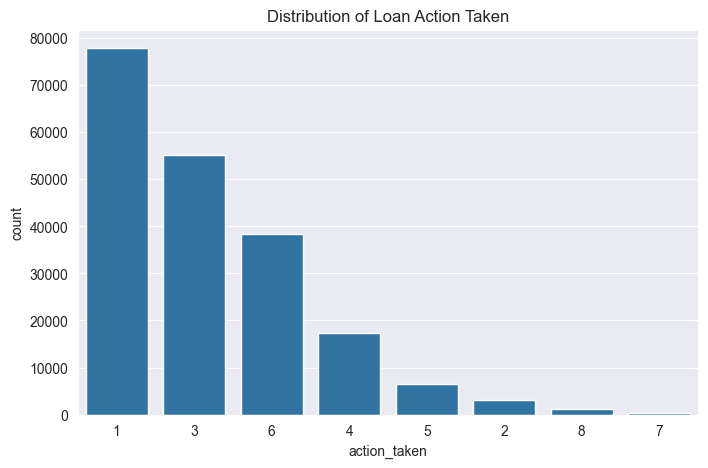

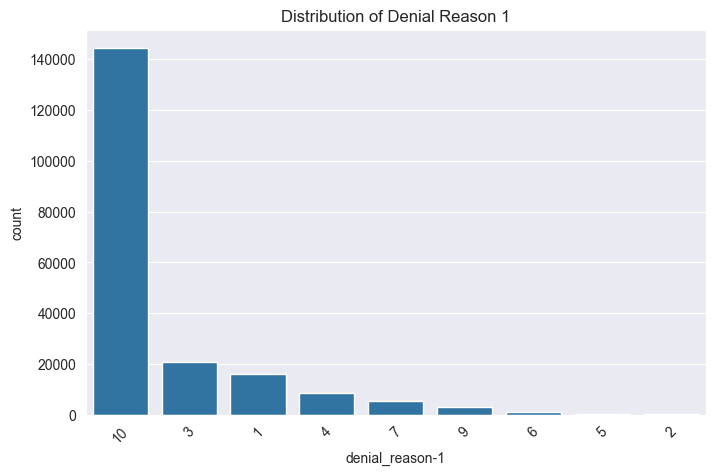

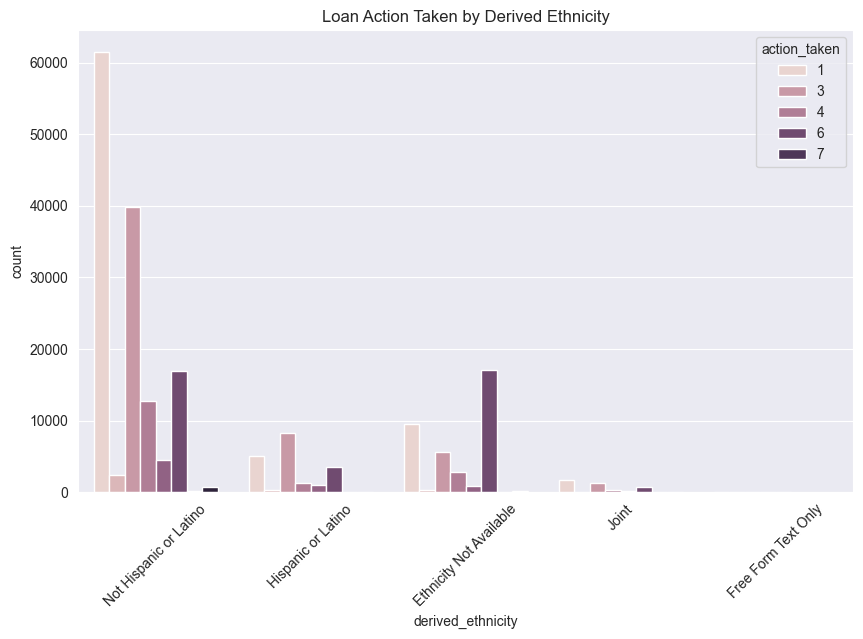

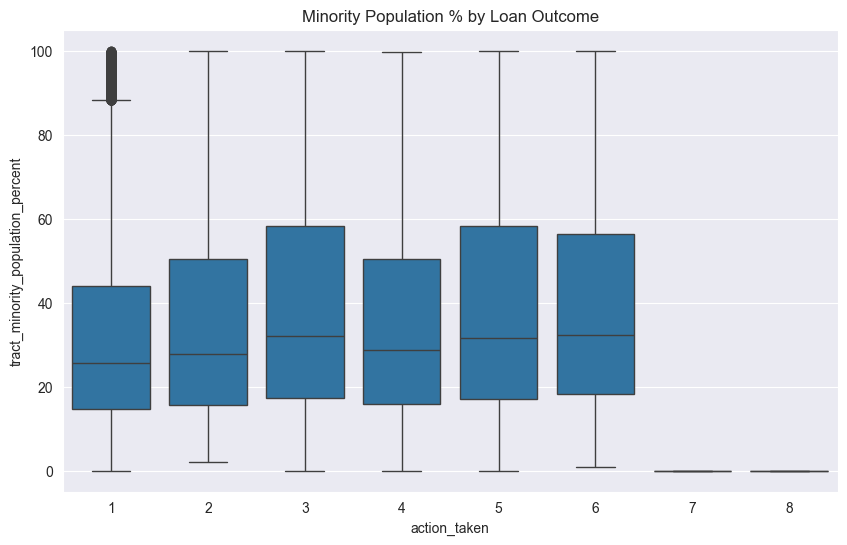

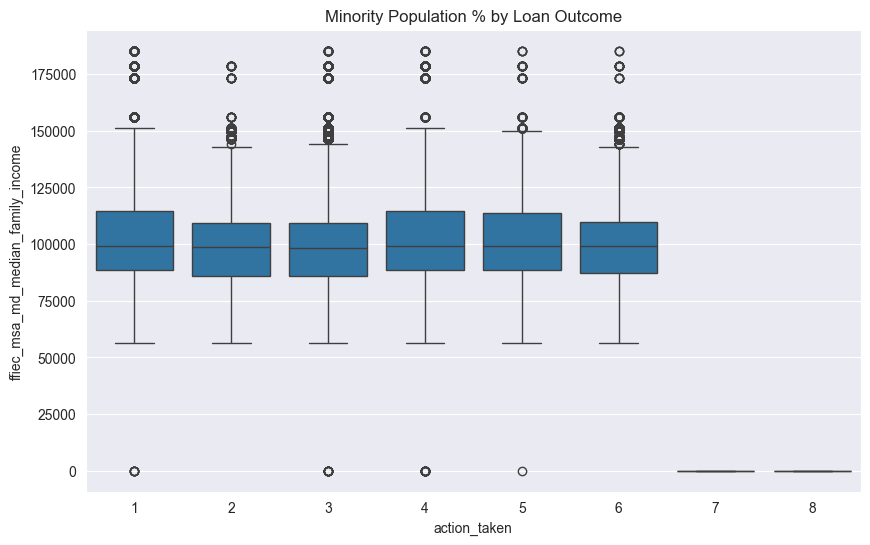

In [12]:
import seaborn as sns

# Loan outcomes overview
plt.figure(figsize=(8,5))
sns.countplot(x="action_taken", data=df, order=df["action_taken"].value_counts().index)
plt.title("Distribution of Loan Action Taken")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x="denial_reason-1", data=df, order=df["denial_reason-1"].value_counts().index)
plt.title("Distribution of Denial Reason 1")
plt.xticks(rotation=45)
plt.show()

# Example comparison: derived_ethnicity vs loan outcomes
plt.figure(figsize=(10,6))
sns.countplot(x="derived_ethnicity", hue="action_taken", data=df)
plt.title("Loan Action Taken by Derived Ethnicity")
plt.xticks(rotation=45)
plt.show()

# Example comparison: tract_minority_population_percent vs loan outcomes
plt.figure(figsize=(10,6))
sns.boxplot(x="action_taken", y="tract_minority_population_percent", data=df)
plt.title("Minority Population % by Loan Outcome")
plt.show()

# Example comparison: tract_minority_population_percent vs loan outcomes
plt.figure(figsize=(10,6))
sns.boxplot(x="action_taken", y="ffiec_msa_md_median_family_income", data=df)
plt.title("Minority Population % by Loan Outcome")
plt.show()



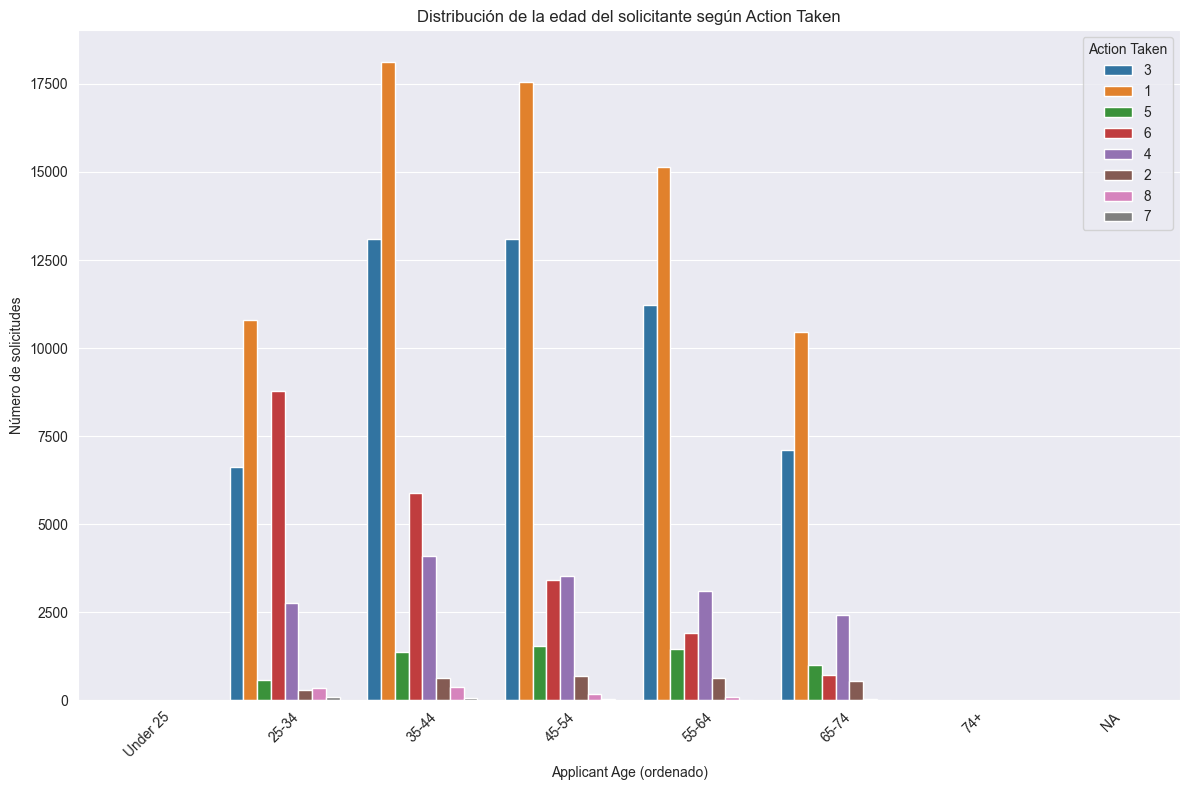

In [13]:
# Definir el orden correcto de applicant_age
age_order = [
    "Under 25",
    "25-34",
    "35-44",
    "45-54",
    "55-64",
    "65-74",
    "74+",
    "NA"
]

# Convertir applicant_age en categoría ordenada
df["applicant_age"] = pd.Categorical(df["applicant_age"], categories=age_order, ordered=True)

# Tratar action_taken como categórico
df["action_taken"] = df["action_taken"].astype(str)

# Crear gráfico de distribución (countplot) para cada action_taken
plt.figure(figsize=(12,8))
sns.countplot(x="applicant_age", hue="action_taken", data=df, order=age_order)
plt.title("Distribución de la edad del solicitante según Action Taken")
plt.xlabel("Applicant Age (ordenado)")
plt.ylabel("Número de solicitudes")
plt.xticks(rotation=45)
plt.legend(title="Action Taken")
plt.tight_layout()
plt.show()


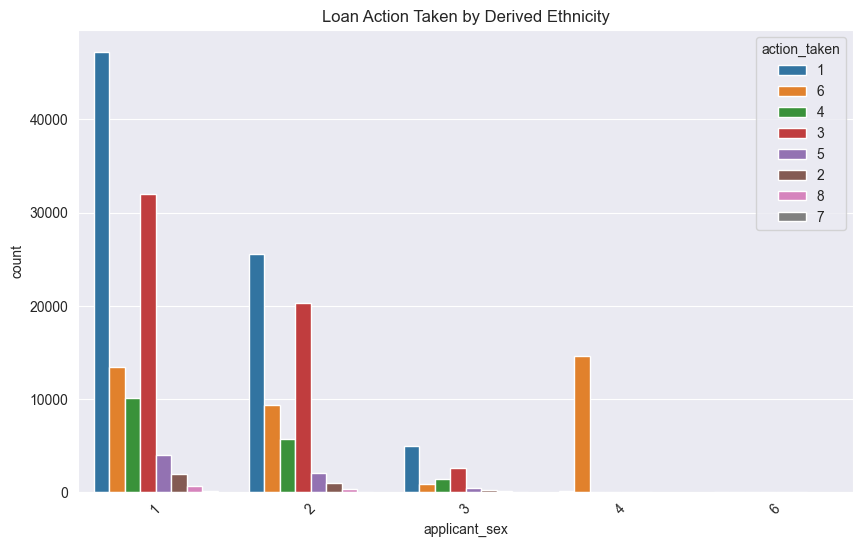

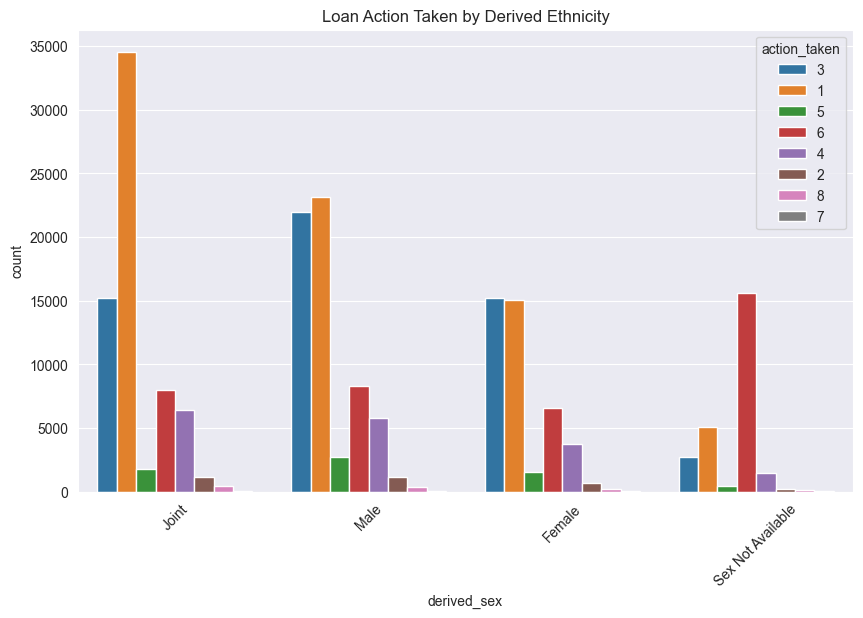

In [15]:
# Example comparison: derived_ethnicity vs loan outcomes
plt.figure(figsize=(10,6))
sns.countplot(x="applicant_sex", hue="action_taken", data=df)
plt.title("Loan Action Taken by Derived Ethnicity")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(x="derived_sex", hue="action_taken", data=df)
plt.title("Loan Action Taken by Derived Ethnicity")
plt.xticks(rotation=45)
plt.show()